# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)] # if the maximum is 20, we have a sequence of length 20
        # so that number 3 will be [0,0,1,0,...,0] and so on.
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq] # in argmax we take the index, so we restore the original number


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1] # here we reverse the sequence

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a dataset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze() # we remove dimensions.
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch2
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the training process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
# Just an example to check the functions and the output
a=generate_sequence(5, 4)
o=one_hot_encode(a, 4)
print(o)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [2]:
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c] # we have all the context vectors and the hidden states produced for each input.

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = keras.layers.Lambda(lambda x: tf.expand_dims(x, 1))(context_vector)


        # create the context vector by applying attention to
        # Concatenate the input + context vector to find the next decoder's input
        inputs = keras.layers.Concatenate(axis=-1)([context_vector, inputs])


        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = keras.layers.Lambda(lambda x: tf.expand_dims(x, 1))(outputs)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [4]:
# dataset
n_timesteps_in = 20  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.0645 - loss: 2.9823 - val_accuracy: 0.0815 - val_loss: 2.9265
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0973 - loss: 2.9001 - val_accuracy: 0.1230 - val_loss: 2.8117
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1369 - loss: 2.7795 - val_accuracy: 0.1532 - val_loss: 2.6984
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1625 - loss: 2.6692 - val_accuracy: 0.1840 - val_loss: 2.6104
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1835 - loss: 2.5799 - val_accuracy: 0.2042 - val_loss: 2.5154
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2081 - loss: 2.4754 - val_accuracy: 0.2253 - val_loss: 2.4249
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2336 - loss: 2.3783 - val_accuracy: 0.2540 - val_loss: 2.2997
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2618 - loss: 2.2535 - val_accuracy: 

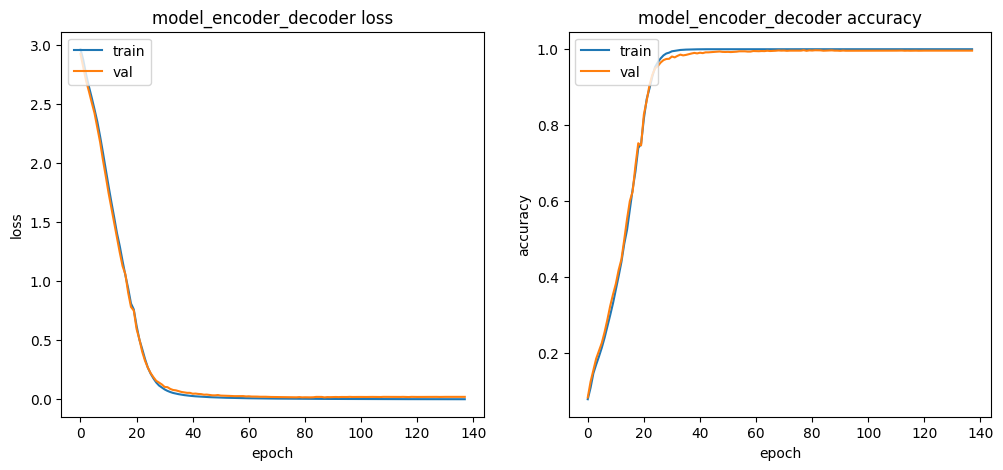

In [9]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=100, epochs=150, patience=50)

### Visualization of attention weights ###

To conclude the project we are going to visualize the attention weights for one example. In this way given a task (in our case to reserve the sentence) we want to check at each step if the attention is properly computed. In other words, since we are reversing, we expect that the first word input is highly correlated to the last word output and so on. In this scenario, then, attention weights should have a anti-diagonal form. The expectation is mostly fullfilled by all the three models considering their different level of accuracy. Indeed while the first two (Luongdot and BahdanauAttention) exhibit the desired pattern, the LuongGeneral, according also to a lower accuracy, shows a not so defined pattern.

In [5]:
def attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention):

  # We set attention plot to zero and then enconde input sequence
  # np.zeros of the length of our sequence of course. SO we want something 100x100 in our case
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(input_sequence,n_features)

  #There is no itialization since we already have them. ENCODER STEP
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs) #memorize the outputs from the LSTM model

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data

  # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
  decoder_outputs = encoder_state_h


  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      #Here we save the attention weights in order to plot them after the function
      attention_weights = tf.reshape(attention_weights, (-1, )) #because we need a unidimensional vector so we reshape it
      attention_plot[t] = attention_weights.numpy()

      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  output_sequence=one_hot_decode(decoder_outputs[0])

  return input_sequence, output_sequence, attention_plot

In [13]:
plt.rcParams.update({'font.size': 18})

In [7]:
import seaborn as sns
import matplotlib.ticker as ticker
from google.colab import files

# We are ready to finally visualize the attention plot. We obtain the output sequence and the attention plot from the previous function,
# then use the plot attention function to finally visualize the relationship between the input sequence and the output sequence.

def visualize(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention):
    input_sequence, output_sequence, attention_plot = attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)
    attention_plot = attention_plot[:len(output_sequence), :len(input_sequence)]
    plot_attention_weights(attention_plot, input_sequence, output_sequence)



#here it is another function to visualize attention weights in a different way:

def plot_attention_weights(attention_weights, input_sequence, output_sequence):
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights, cmap='viridis', annot=False, xticklabels=input_sequence, yticklabels=output_sequence)
    plt.title('Attention Weights')
    plt.xlabel('Input Sequence', labelpad=15)
    plt.ylabel('Output Sequence', labelpad=15)
    plt.savefig("Attention_w_diag.pdf", format='pdf', bbox_inches='tight')
    files.download("Attention_w_diag.pdf")
    plt.show()





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

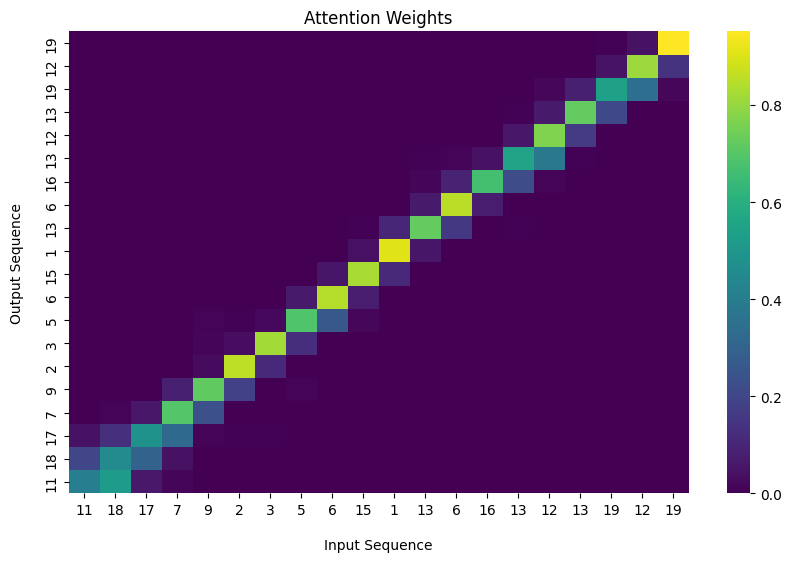

In [10]:
input_sequence=generate_sequence(n_timesteps_in,n_features)
visualize(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)


### Structure Extraction

Here we write the code to extract the structure from the attention weights matrices. The idea, to obtain the general structure is to extract $n$ points (here since the dataset is random, we simply take random entries) add the matrices (we have fixed length), cut under a certain level (threshold $l$) normalize by row and then print the general attention weight matrix.

In [23]:
def structure_extraction(n, l):
    """
    Extract the structure of attention matrix

    :n: Number of points
    :l: thresold to cut attention aggregation
    :attention_w: attention_w
    """
    aggregated_matrix = np.zeros((n_timesteps_in, n_timesteps_in))
    for i in range(n):
        input_sequence=generate_sequence(n_timesteps_in,n_features) # we generate a sample
        _, output_sequence, attention_weights = attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)
        attention_matrix = attention_weights[:len(output_sequence), :len(input_sequence)]
        aggregated_matrix += attention_matrix

    aggregated_matrix = aggregated_matrix / n
    aggregated_matrix = np.where(aggregated_matrix < l, 0, aggregated_matrix)
    aggregated_matrix = aggregated_matrix / np.sum(aggregated_matrix, axis=1, keepdims=True)

    return aggregated_matrix

In [24]:
structure_matrix = structure_extraction(100, 0.05)

plt.figure(figsize=(10, 6))
sns.heatmap(structure_matrix, cmap='viridis', annot=False)
plt.title('Attention Structure')
plt.xlabel('General Input Sequence', labelpad=15)
plt.ylabel('General Output Sequence', labelpad=15)
plt.show()

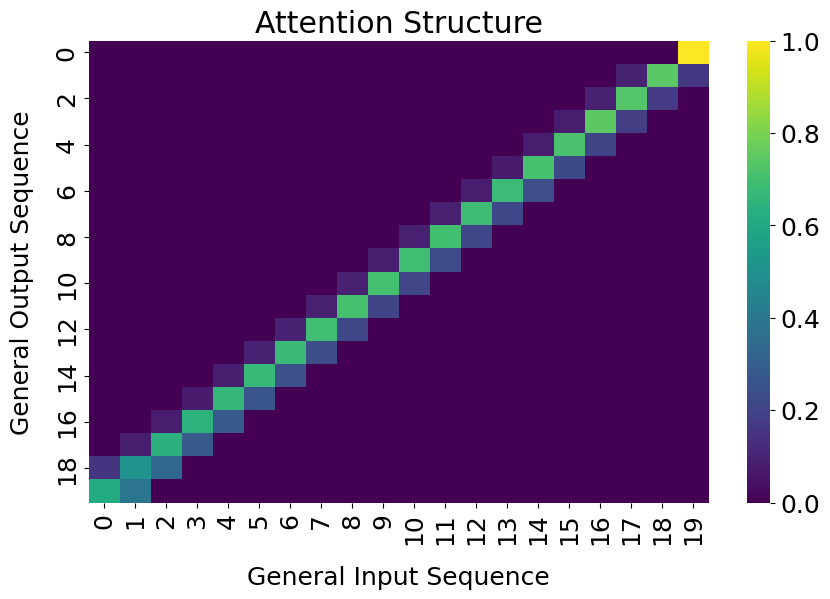

### Evolution of Attention Structure

We visualize the impact of increasing $l$ for the structure

In [11]:
aggregated_matrix = np.zeros((n_timesteps_in, n_timesteps_in))
for i in range(100):
    aggregated_matrix = np.zeros((n_timesteps_in, n_timesteps_in))
    input_sequence=generate_sequence(n_timesteps_in,n_features) # we generate a sample
    _, output_sequence, attention_weights = attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)
    attention_matrix = attention_weights[:len(output_sequence), :len(input_sequence)]
    aggregated_matrix += attention_matrix
    aggregated_matrix = aggregated_matrix / 100
    aggregated_matrix = aggregated_matrix / np.sum(aggregated_matrix, axis=1, keepdims=True)


In [15]:
# Save the variable
import pickle
with open('aggregated_matrix.pkl', 'wb') as f:
    pickle.dump(aggregated_matrix, f)

files.download('aggregated_matrix.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

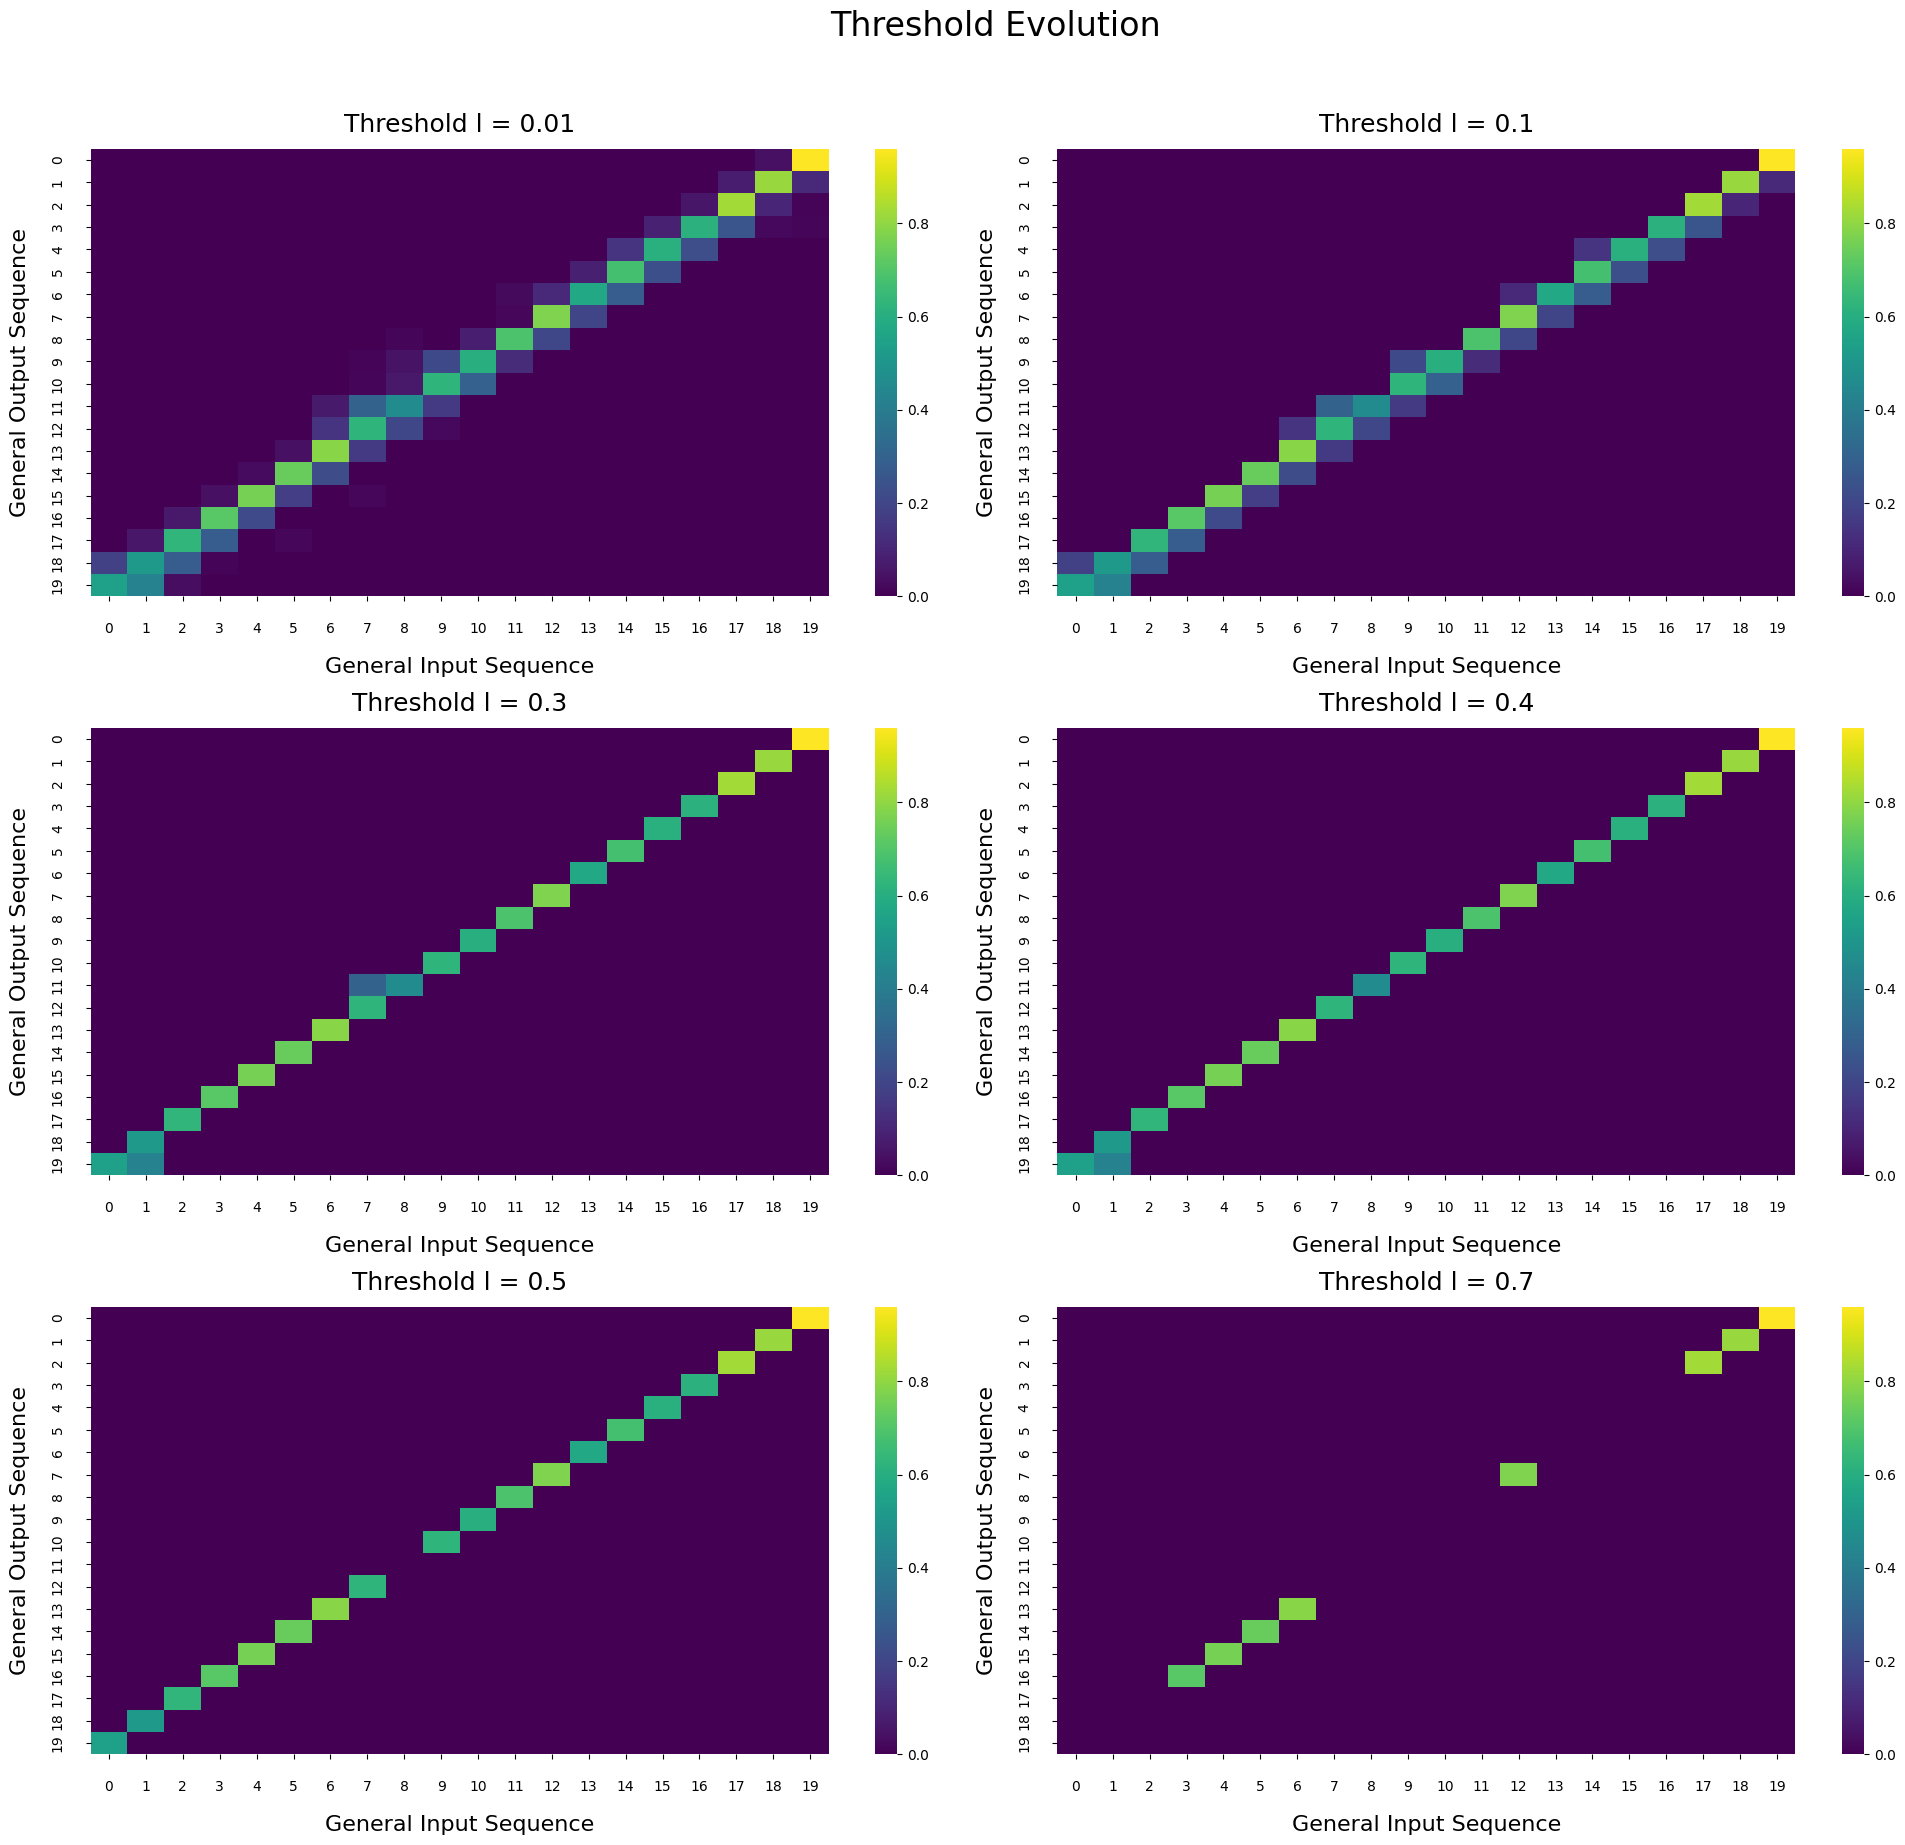

In [27]:
l_values = [0.01, 0.1, 0.3, 0.4, 0.5, 0.7]

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle("Threshold Evolution", fontsize=24, y=0.92)

for idx, l in enumerate(l_values):
    # Calcola la struttura per il threshold corrente
    structure_matrix = aggregated_matrix.copy()
    structure_matrix = np.where(structure_matrix < l, 0, structure_matrix)

    ax = axes[idx // 2, idx % 2]

    sns.heatmap(structure_matrix, cmap='viridis', annot=False, ax=ax,
                cbar=True,
                xticklabels=True, yticklabels=True)

    ax.set_title(f"Threshold l = {l}", fontsize=18, pad=12)

    ax.set_xlabel("General Input Sequence", fontsize=16, labelpad=15)
    ax.set_ylabel("General Output Sequence", fontsize=16, labelpad=15)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig("Threshold_evolution.pdf", format='pdf', bbox_inches='tight')
files.download("Threshold_evolution.pdf")
plt.show()


